In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Processing Functions For Threshold Detection

In [3]:
def read_bin_data(path:str)->np.array:
    data = np.fromfile(path, dtype=np.int16)
    data = np.reshape(data, (data.size//2, 2))
    return data[:,0] + 1j*data[:,1]

In [4]:
def filter_data(data:np.array, num_taps:int=64, fc:float=0.1, gain:float=1, window='hamming')->np.array:
    taps = sp.signal.firwin(num_taps, fc)
    real = sp.signal.lfilter(taps, 1.0, np.real(data))
    imag = sp.signal.lfilter(taps, 1.0, np.imag(data))
    processed_data = real + 1j*imag
    return processed_data 

In [5]:
def normalize_data(data:np.array)->np.array:
    return data / np.max(data)

In [6]:
def detect_threshold(data:np.array, threshold:float=0.8)->int: #detect threshold return
    return np.argwhere(data>threshold)[0][0]

In [7]:
def get_start_end_idx(thr_idx:int, fs:int)->tuple:
    thr_time = thr_idx / fs
    start_time = thr_time - 5e-3
    end_time = start_time + 30e-3
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)
    return (start_idx, end_idx)

In [22]:
def process_data(raw_data:np.array, fs:int)->np.array:
    num_taps = 64
    fc = 0.1
    gain = 5
    window = 'hamming'
    print('Processing Data: filtering...')
    proc_data = filter_data(raw_data, num_taps, fc, gain, window)
    print('Processing Data: Threshold Detction...')
    proc_data = normalize_data(proc_data)
    thr_idx = detect_threshold(proc_data, 0.8)
    print('\tThreshold Detected at idx: {}'.format(thr_idx))
    del proc_data
    idx0, idx1 = get_start_end_idx(thr_idx, fs)
    print('\tSaving pulse starting {} and ending {}'.format(idx0, idx1))
    pulse_data = raw_data[idx0:idx1]
    del raw_data
    return idx0, pulse_data
    print('Done Processing!') 

## Testing the Processing funtions

In [9]:
file_path = './20230527_test_data/raw_data_10m_10dB_17in_vin.bin'
print('reading data from: ' + file_path)
raw_data = read_bin_data(file_path)
fs = 25e6
pulse_data = process_data(raw_data, fs)

reading data from: ./20230527_test_data/raw_data_10m_10dB_17in_vin.bin
Processing Data: filtering...
Processing Data: Threshold Detction...
	Threshold Detected at idx: 17174431
	Saving pulse starting 17049431 and ending 17799431


C:\Users\josep\Documents\Programming\Python\envs\myenv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


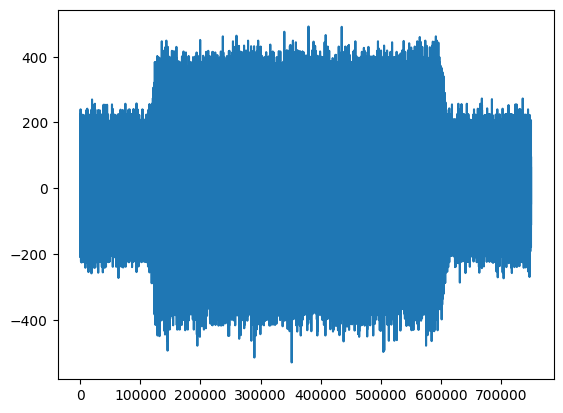

In [10]:
plt.plot(pulse_data)
del raw_data
del pulse_data

## Host Controller Simutions

In [27]:
fs = 25e6

file_path = './20230527_test_data/raw_data_10m_10dB_17in_joey.bin'
print('reading data from: ' + file_path)
raw_data = read_bin_data(file_path)
timestamp_0, pulse_data_0 = process_data(raw_data, fs)
del raw_data

file_path = './20230527_test_data/raw_data_10m_10dB_17in_vin.bin'
print('reading data from: ' + file_path)
raw_data = read_bin_data(file_path)
timestamp_1, pulse_data_1 = process_data(raw_data, fs)
del raw_data

reading data from: ./20230527_test_data/raw_data_10m_10dB_17in_joey.bin
Processing Data: filtering...
Processing Data: Threshold Detction...
	Threshold Detected at idx: 17186625
	Saving pulse starting 17061625 and ending 17811625
reading data from: ./20230527_test_data/raw_data_10m_10dB_17in_vin.bin
Processing Data: filtering...
Processing Data: Threshold Detction...
	Threshold Detected at idx: 17174431
	Saving pulse starting 17049431 and ending 17799431


In [28]:
#take the magnitude and correlate the raw data pulses to find TDOA
pulse_data_0 = normalize_data(filter_data(pulse_data_0))
pulse_data_1 = normalize_data(filter_data(pulse_data_1))
mag_data_0 = np.abs(pulse_data_0)
mag_data_1 = np.abs(pulse_data_1)

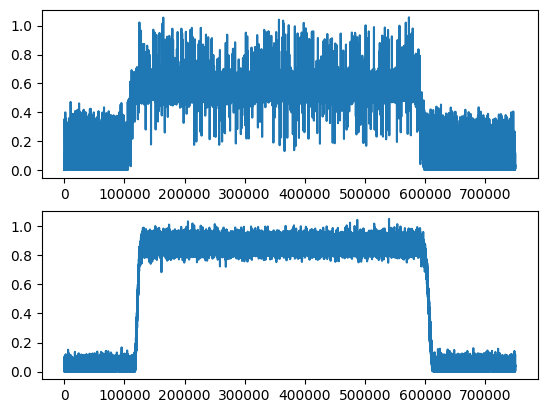

In [29]:
plt.subplot(211)
plt.plot(mag_data_0)
plt.subplot(212)
plt.plot(mag_data_1)

In [47]:
print('Pulse 0 data starts at idx = {}'.format(timestamp_0))
print('Pulse 1 data starts at idx = {}'.format(timestamp_1))
print('Index difference is {}'.format(np.abs(timestamp_0-timestamp_1)))

Pulse 0 data starts at idx = 17061625
Pulse 1 data starts at idx = 17049431
Index difference is 12194


In [49]:
xcorr = sp.signal.fftconvolve(mag_data_0, mag_data_1)
corr_peak = np.argmax(xcorr)

In [60]:
print('Pulse 0 length = {}'.format(pulse_data_0.size))
print('Pulse 1 length = {}'.format(pulse_data_1.size))
print('Correlation Peak found at {}'.format(corr_peak))
print('Differnce in corr peak and data length = {}'.format(pulse_data_0.size - corr_peak))
k = np.abs(np.abs(pulse_data_0.size-corr_peak) - np.abs(timestamp_0-timestamp_1))
print('Taking into account starting indicies {}'.format(k))
print('TDOA Pulse 0 and Pulse 1 = {} ns'.format(1e9*(k / fs)))

Pulse 0 length = 750000
Pulse 1 length = 750000
Correlation Peak found at 715932
Differnce in corr peak and data length = 34068
Taking into account starting indicies 21874
TDOA Pulse 0 and Pulse 1 = 874960.0 ns


340933


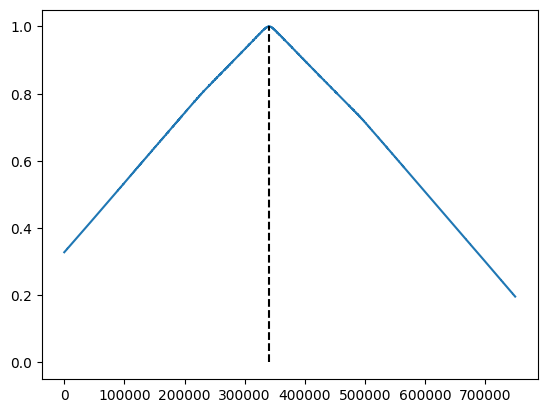

In [43]:
plt.plot(xcorr/np.max(xcorr))
plt.vlines(corr_peak, 0, 1, colors='k', linestyle='--')
print(corr_peak)